In [2]:
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
from scipy import interpolate
from statsmodels.tsa.stattools import adfuller
from sktime.split import temporal_train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
import seaborn as sns

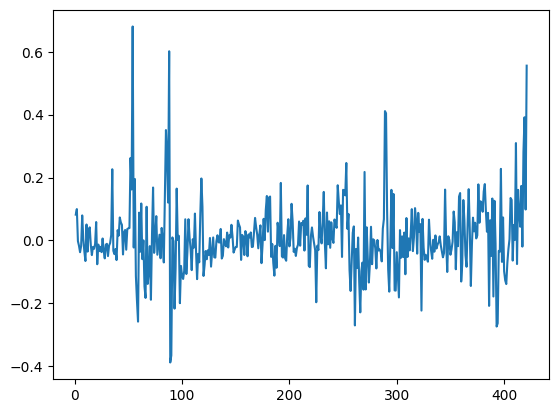

In [3]:
names = ["Brazil", "Colombia", "Vietnam", "Indonesia", "Honduras"]
data_dict = {}  

for name in names:
    input_file = f"../data/{name}_weather_cleaned.csv" 
    data_dict[name] = pd.read_csv(input_file)  

commodity_prices = pd.read_csv("../data/global_commodity_prices.csv")

currency = ["brl","cop", "hnl", "idr", "vnd"]

exchange_dict = {}
for c in currency:
     input_file = f"../data/{c}_data_clean.csv"
     exchange_dict[c] = pd.read_csv(input_file)

coffee_futures = pd.read_csv("../data/ICEUS_DLY_KC1!, 1M.csv")
gdp_exporters = pd.read_excel("../data/GDP_Exporters.xlsx")

commodity_prices["Coffee"].diff().dropna()
plt.plot(commodity_prices["Coffee"].diff().dropna())

In [4]:

coffee_futures = coffee_futures[pd.to_datetime(coffee_futures["time"], errors="coerce").dt.year.between(1990, 2024)]

commodity_prices['Milk'] = commodity_prices['Milk'].fillna(commodity_prices['Milk'].mean())
commodity_prices["Date"] = pd.to_datetime(commodity_prices["Date" ], errors= "coerce")
commodity_prices = commodity_prices[commodity_prices["Date"].dt.year !=2025]

gdp_exporters.replace("..", pd.NA, inplace=True)
gdp_exporters_cleaned = gdp_exporters.dropna(axis=1, how="all")

exchange_dict["vnd"]["Date"] = pd.to_datetime(exchange_dict["vnd"]["Date"])

last_date = exchange_dict["vnd"]["Date"].iloc[-1]  # Get the last date
new_date = last_date + pd.DateOffset(months=1)  # Desired next month

# Step 3: Compare if the new date's month is greater than the last date's month
if new_date.month > last_date.month:
    # Create a new row with NaN for 'vnd Exchange Rate'
    nan_row = pd.DataFrame([[new_date, np.nan]], columns=exchange_dict["vnd"].columns)

    # Append the new row to the DataFrame
    exchange_dict["vnd"] = pd.concat([exchange_dict["vnd"], nan_row], ignore_index=True)

    # Optionally, fill the new row with the previous valid value
    exchange_dict["vnd"].iloc[-1, exchange_dict["vnd"].columns.get_loc('vnd Exchange Rate')]


exchange_dict["vnd"] = exchange_dict["vnd"].interpolate(method="linear")


C:\Users\Admin\AppData\Local\Temp\ipykernel_27608\3206684264.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  commodity_prices["Date"] = pd.to_datetime(commodity_prices["Date" ], errors= "coerce")
C:\Users\Admin\AppData\Local\Temp\ipykernel_27608\3206684264.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exchange_dict["vnd"]["Date"] = pd.to_datetime(exchange_dict["vnd"]["Date"])


In [5]:
y = commodity_prices["Coffee"]
adfuller(y)
# Fail to reject null, so there is evidence for unit root(non-stationarity)
y_diff = y.diff()
y_diff = y_diff.dropna()
adfuller(y_diff)
# Reject null, so evidence for stationarity


(np.float64(-11.259320329592692),
 np.float64(1.6369634758747206e-20),
 1,
 417,
 {'1%': np.float64(-3.446129402876608),
  '5%': np.float64(-2.8684960761128346),
  '10%': np.float64(-2.570475362616382)},
 np.float64(-629.8496346048919))

In [6]:
Date = commodity_prices["Date"]
# List of country names
countries = ["Brazil", "Colombia", "Vietnam", "Indonesia", "Honduras"]

y_lag = commodity_prices["Coffee"].shift(1).dropna()

# Create a dictionary to store the weather dataframes with renamed columns
weather_data = {}

# Iterate through each country to process and store the weather data with country-specific column names
for country in countries:
    country_weather = data_dict[country][["temperature_2m_mean", "daylight_duration", "sunshine_duration", 
                                         "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max", 
                                         "et0_fao_evapotranspiration"]].diff()
    country_weather = country_weather.dropna()
    
    # Rename columns by adding the country name as a prefix
    country_weather.columns = [f"{country}_{col}" for col in country_weather.columns]
    
    # Add the processed data to the dictionary
    weather_data[country] = country_weather


brl = exchange_dict["brl"]["brl Exchange Rate"].diff()
brl = brl.dropna()
cop = exchange_dict["cop"]["cop Exchange Rate"].diff()
cop = cop.dropna()
hnl = exchange_dict["hnl"]["hnl Exchange Rate"].diff()
hnl = hnl.dropna()
idr = exchange_dict["idr"]["idr Exchange Rate"].diff()
idr = idr.dropna()
vnd = exchange_dict["vnd"]["vnd Exchange Rate"].diff()
vnd = vnd.dropna()


sugar = commodity_prices["Sugar"].diff()
sugar = sugar.dropna()
tea = commodity_prices["Tea"].diff()
tea = tea.dropna()
milk = commodity_prices["Milk"].diff()
milk = milk.dropna()

future = coffee_futures["close"].diff()
future = future.dropna()
future = future.reset_index()


X = pd.concat([y_lag, weather_data["Brazil"], weather_data["Colombia"], weather_data["Honduras"], weather_data["Indonesia"], weather_data["Vietnam"], 
               brl, cop, hnl, idr, vnd, sugar, tea, milk, future], axis=1).dropna()

X = X.drop("index" , axis = 1)
X

,Coffee,Brazil_temperature_2m_mean,Brazil_daylight_duration,Brazil_sunshine_duration,Brazil_precipitation_sum,Brazil_wind_speed_10m_max,Brazil_wind_gusts_10m_max,Brazil_et0_fao_evapotranspiration,Colombia_temperature_2m_mean,Colombia_daylight_duration,...,Vietnam_et0_fao_evapotranspiration,brl Exchange Rate,cop Exchange Rate,hnl Exchange Rate,idr Exchange Rate,vnd Exchange Rate,Sugar,Tea,Milk,close
1,0.758300,0.208859,-0.381403,-1.090787,3.558295,0.522997,2.235484,-0.806422,0.286542,0.092397,...,0.589904,0.000004,11.64,0.0000,5.020000,0.000000,0.004500,-0.188876,0.000000,-1.65
2,0.840100,0.216074,-0.489844,0.935620,-2.600230,-1.354169,-3.907742,-0.009820,0.091683,0.123630,...,0.428266,0.000006,11.68,2.0000,10.480000,0.000000,0.006600,-0.084776,0.000000,1.59
3,0.939600,-0.498311,-0.504389,-0.470159,-1.465484,0.924364,1.375742,-0.355095,0.021616,0.133065,...,-0.524620,0.000004,11.22,0.0000,5.700000,0.000000,-0.000700,0.010024,0.000000,0.32
4,0.937300,-2.016945,-0.413751,-1.396933,0.836452,0.403184,1.202322,-1.006043,-0.095741,0.113191,...,-0.570282,0.000002,11.37,0.2000,5.350000,84.101337,-0.006200,-0.035335,0.000000,-8.45
5,0.920200,-1.447083,-0.204005,0.122245,-1.513118,0.275422,-0.278322,-0.095519,0.064422,0.056924,...,-1.116660,0.000002,11.32,0.0000,9.600000,489.316870,-0.016500,-0.025084,0.000000,8.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.484050,-0.400726,0.104234,0.409114,-0.040430,-0.122595,0.579484,0.388580,0.466822,-0.029170,...,-1.069288,0.153073,-17.76,0.1146,-67.736063,-1.240000,0.001822,0.030359,0.003389,14.85
415,2.570987,1.245363,0.358129,0.087216,0.212903,1.929350,3.193548,0.689471,-0.107393,-0.098828,...,1.016583,0.010566,26.18,0.0244,-468.471008,-5.710000,-0.009322,0.103634,0.002571,26.20
416,2.614377,2.994251,0.477771,0.847390,-0.209140,0.965005,1.302967,1.450997,0.906405,-0.127873,...,-1.017887,-0.011047,128.88,-0.0445,-451.931818,-82.310000,0.022052,0.105838,0.006766,-24.35
417,2.787605,0.094189,0.507343,-2.189851,4.980108,-1.802376,-3.660387,-1.554608,-1.046996,-0.130060,...,0.208093,0.082542,65.90,0.1280,200.097826,28.980000,0.017305,-0.082758,-0.012874,72.15


In [7]:
X_train, X_test, y_train, y_test = temporal_train_test_split(X, y_diff, test_size=0.2)
y_train = y_train.ravel() 
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")



Train size: 334, Test size: 84


C:\Users\Admin\AppData\Local\Temp\ipykernel_27608\2089144264.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

# pca = PCA(n_components=0.95)  # Retain 95% of the variance
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)

# # Train KNN Regressor on the PCA-reduced features
# knn = KNeighborsRegressor(n_neighbors=3)
# knn.fit(X_train_pca, y_train)
# y_pred = knn.predict(X_val_pca)


In [9]:
knn_regressor = KNeighborsTimeSeriesRegressor(n_neighbors=3)


knn_regressor.fit(X_train_trans , y_train)
y_hat_train = knn_regressor.predict(X_train_trans)
y_hat_test = knn_regressor.predict(X_test_trans)



In [12]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print(train_mse)
print(test_mse)



0.005822079351290226
0.021196162258791045


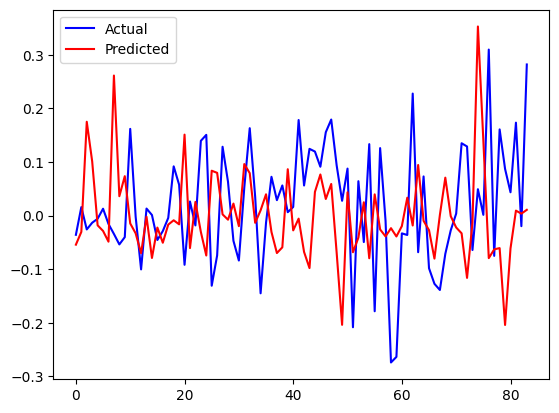

In [13]:
plt.plot(np.array(y_test), label='Actual', color = "blue")
plt.plot(y_hat_test, label='Predicted', color = "red")
plt.legend()